In [50]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict


from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore


from dotenv import load_dotenv
import os
from langchain.document_loaders import JSONLoader
import numpy as np
import matplotlib.pyplot as plt


In [5]:
load_dotenv(override=True)  # This will load environment variables from .env file

True

In [52]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-large") ## why?
vector_store = InMemoryVectorStore(embeddings) # why?
llm = ChatOpenAI(model="gpt-4o-mini") # why?

In [53]:
# Create loaders for each JSON file
loader1 = JSONLoader(
    file_path="userModel/how.json",
    jq_schema='.', #Get everything (entire JSON)
    text_content=False
)

loader2 = JSONLoader(
    file_path="userModel/whereTo.json",
    jq_schema='.', #Get everything (entire JSON)
    text_content=False
)

loader3 = JSONLoader(
    file_path="userModel/who.json",
    jq_schema='.', #Get everything (entire JSON)
    text_content=False
)

# Combine documents from all loaders
documents = []
for loader in [loader1, loader2, loader3]:
    documents.extend(loader.load())


In [43]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200, 
    chunk_overlap=40,
    separators=["{", "}", ",", "\n"]
    )
all_splits = text_splitter.split_documents(documents)

In [54]:
print(len(all_splits))
for doc in all_splits:
    print(doc)

32
page_content='{"subPlan": [{"goal":' metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\how.json', 'seq_num': 1}
page_content='{"description": "Secure a job in Software Engineering or Machine Learning", "deadline": "2025-03-31"' metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\how.json', 'seq_num': 1}
page_content='}, "justification": "Jimmy has a strong passion for continuous improvement, making a positive difference, and leveraging his skills in programming and problem-solving.", "actionItem": [' metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\how.json', 'seq_num': 1}
page_content='{"what": "Complete and refine resume and LinkedIn profile", "when": "2025-01-07", "duration": "2 hours"},' metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\how.json', 'seq_num': 1}
page_content='{"what": "Apply to at least 5 jobs weekl

In [55]:
# Index chunks
_ = vector_store.add_documents(documents=all_splits)

In [81]:
# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

def getScore(cosineSimilarity):
    return cosineSimilarity #abs(cosineSimilarity)
# Define application steps

def retrieve(state: State, minRelevance = 0.7, stdDev = 0.5, showDistribution = True, document = None):
    raw_results = vector_store.similarity_search_with_score(state["question"], k = len(all_splits)) # score is cosine similarity
    print("len raw_results", len(raw_results))
    if len(raw_results) == 1:
        return {"context": [raw_results[0][0]]}
    else:
        # I think absolute value of score measures true similarity, will test this hypothesis somehow
        scores = np.array([getScore(cosine_similarity) for _, cosine_similarity in raw_results])
        indicesAboveMinRelevance = np.where(scores > minRelevance)[0]
        #meanScore = np.mean(scores)
        #stdScore = np.std(scores)
        if showDistribution:
            plt.hist(scores)
            plt.show()

        if len(indicesAboveMinRelevance):
            return {"context": [raw_results[i][0] for i in indicesAboveMinRelevance]} # return all documents above minRelevance
        else:
            #maxScoreIndex = np.argmax(scores)
            return {"context": [raw_results[0][0]]} # return the most relevant documen

def generate(state: State):
    print("state['context']", state["context"])
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


C:\Users\garre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [82]:
# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

len raw_results 32


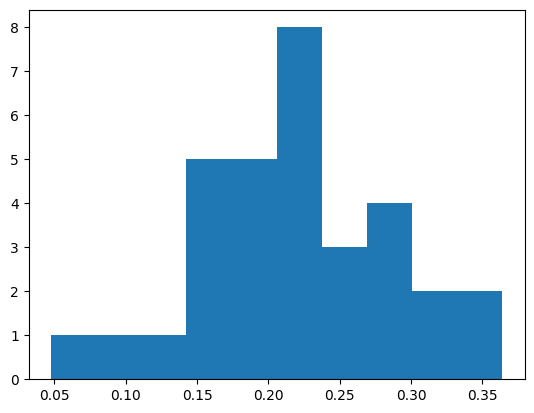

AttributeError: 'tuple' object has no attribute 'page_content'

In [83]:
graph.invoke({"question": "Given your knowledge of where I'd like to go, and the plan we've agreed upon, what should I be doing on a daily basis?"})

len raw_results 32


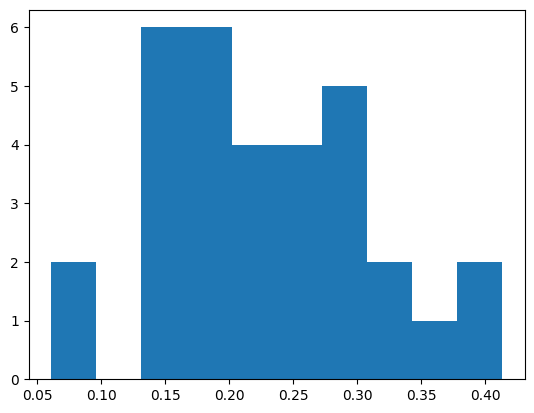

AttributeError: 'tuple' object has no attribute 'page_content'

In [84]:
graph.invoke({"question": "Given the plan we've agreed upon, what should I be doing on a daily basis?"})

len raw_results 32


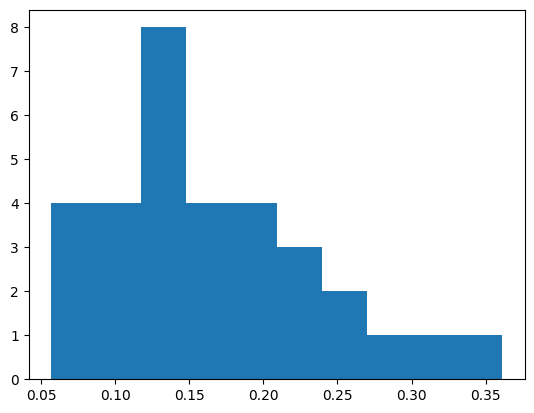

AttributeError: 'tuple' object has no attribute 'page_content'

In [79]:
graph.invoke({"question": "What's the best way for me to approach the job search, given what you know about me?"})